In [ ]:
from src.pipeline import VSFStableDiffusion3Pipeline

In [ ]:
import torch
pipe = VSFStableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-large-turbo",
    torch_dtype=torch.bfloat16,
).to("cuda")

In [ ]:
import torch
from nag import NAGStableDiffusion3Pipeline

pipe_nag = NAGStableDiffusion3Pipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    text_encoder_2=pipe.text_encoder_2,
    text_encoder_3=pipe.text_encoder_3,
    tokenizer=pipe.tokenizer,
    tokenizer_2=pipe.tokenizer_2,
    tokenizer_3=pipe.tokenizer_3,
    scheduler=pipe.scheduler,
    transformer=pipe.transformer,
)

In [ ]:
# VSF
prompt = "A poker table is set in the casino room, green felt stretched tight over the oval surface."
negative_prompt = "cards"
image_ours = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=0.0,
    num_inference_steps=8,
    scale=3.5,
    offset=0.1
).images[0]

In [ ]:
# NAG
image_nag = pipe_nag(
    prompt,
    nag_negative_prompt=negative_prompt,
    guidance_scale=0.,
    nag_scale=5,
    nag_alpha=0.7,
    nag_tau=6.5,
    num_inference_steps=8,
).images[0]

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
plt.subplot(1, 2, 1)
plt.imshow(image_ours)
plt.title("VSF")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_nag)
plt.title("NAG")
plt.axis("off")

In [ ]:
import torch
from src.flux_pipeline import VSFFluxPipeline
import numpy as np
import imageio

pipe = VSFFluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16).to("cuda:2")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


torch.Size([1, 256, 4096]) torch.Size([256, 3]) torch.Size([1, 4, 4096]) torch.Size([4, 3])


  0%|          | 0/3 [00:00<?, ?it/s]

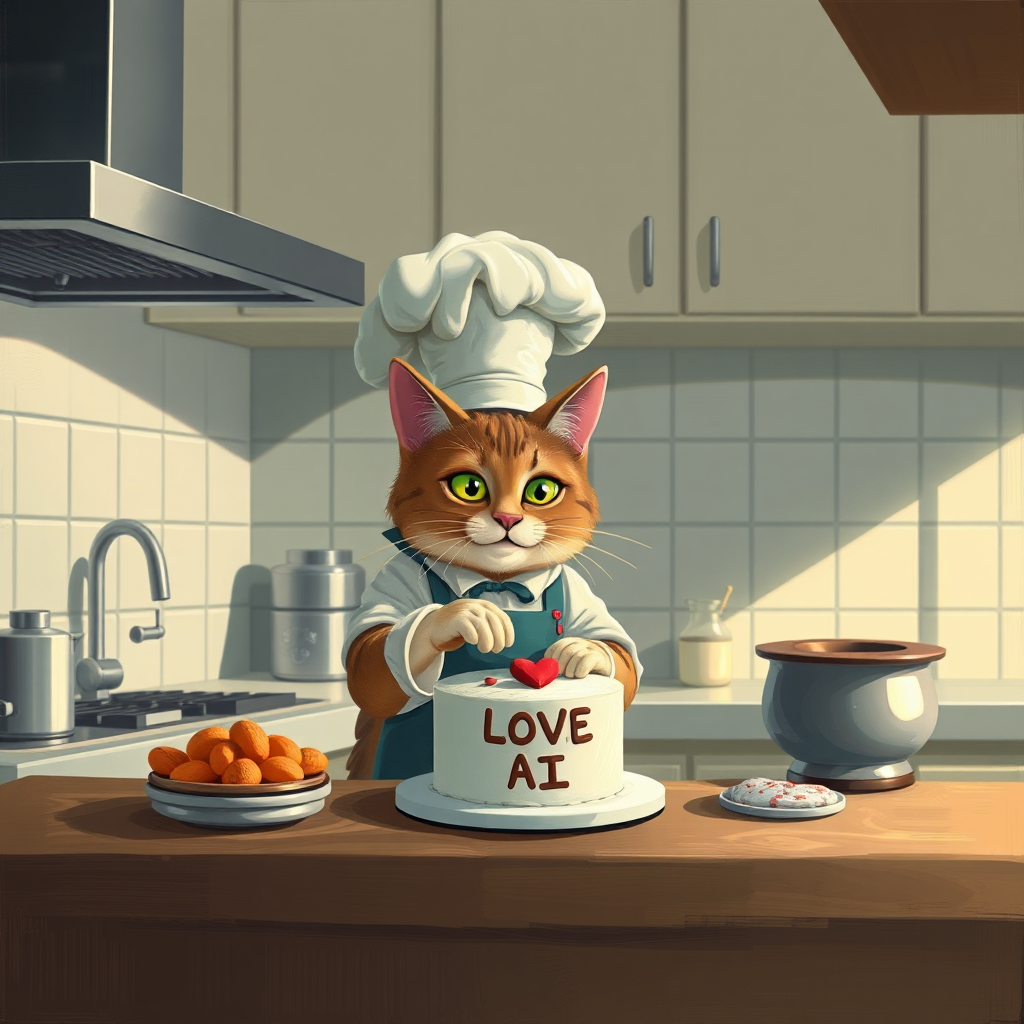

In [ ]:
prompt = "a chef cat making a cake in the kitchen, the kitchen is modern and well-lit, the text on cake is saying 'I LOVE AI, the whole image is in oil paint style'"
image = pipe(
    prompt,
    negative_prompt="icing",
    guidance_scale=0.0,
    num_inference_steps=3,
    max_sequence_length=256,
    scale=4,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image

In [ ]:
prompt = "a chef cat making a cake in the kitchen, the kitchen is modern and well-lit with the cake saying 'rm -rf /'"
image_normal = pipe(
    prompt,
    negative_prompt="chef hat",
    guidance_scale=0.0,
    num_inference_steps=8,
    max_sequence_length=256,
    scale=0,
    offset=torch.inf,
    generator=torch.Generator("cpu").manual_seed(19)
).images[0]

image_vsf = pipe(
    prompt,
    negative_prompt="chef hat",
    guidance_scale=0.0,
    num_inference_steps=8,
    max_sequence_length=256,
    scale=3.5,
    generator=torch.Generator("cpu").manual_seed(19)
).images[0]


torch.Size([1, 256, 4096]) torch.Size([256, 3]) torch.Size([1, 4, 4096]) torch.Size([4, 3])


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([1, 256, 4096]) torch.Size([256, 3]) torch.Size([1, 4, 4096]) torch.Size([4, 3])


  0%|          | 0/8 [00:00<?, ?it/s]

In [2]:
import torch
from diffusers import AutoencoderKLWan
from vsfwan.pipeline import WanPipeline
from vsfwan.processor import WanAttnProcessor2_0
from diffusers import WanVACEPipeline
from diffusers.utils import export_to_video

model_id = "Wan-AI/Wan2.1-T2V-1.3B-Diffusers"
vae = AutoencoderKLWan.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float32)
pipe = WanPipeline.from_pretrained(model_id, vae=vae, torch_dtype=torch.bfloat16)
pipe.load_lora_weights(
    "Kijai/WanVideo_comfy",
    weight_name="Wan21_CausVid_bidirect2_T2V_1_3B_lora_rank32.safetensors",
    adapter_name="lora"
) 
pipe = pipe.to("cuda")

# prompt = "A chef cat and a dog baking a cake together in a kitchen. The cat is carefully measuring flour, while the dog is stirring the batter with a wooden spoon. The cat is wearing a chef suit"
# neg_prompt = "chef hat"
prompt = "A cessna flying over a snowy mountain landscape, with a clear blue sky and fluffy white clouds. The plane is flying at a low altitude, casting a shadow on the snow-covered ground below. The mountains are rugged and steep, with patches of evergreen trees visible in the foreground."
neg_prompt = "trees"

neg_prompt_embeds, _ = pipe.encode_prompt(
    prompt=neg_prompt,
    padding=False,
    do_classifier_free_guidance=False,
)

pos_prompt_embeds, _ = pipe.encode_prompt( 
    prompt=prompt,
    do_classifier_free_guidance=False, 
    max_sequence_length=512 - neg_prompt_embeds.shape[1],
)



neg_len = neg_prompt_embeds.shape[1]
pos_len = pos_prompt_embeds.shape[1]
print(neg_len, pos_len)


img_len = (height//8) * (width//8) * 3 * (frames // 4 + 1) // 12
print(img_len)
mask = torch.zeros((1, img_len, pos_len+neg_len)).cuda()
mask[:, :, -neg_len:] = -0.2 # this should be negative

for block in pipe.transformer.blocks: 
    block.attn2.processor = WanAttnProcessor2_0(scale=1.7, neg_prompt_length=neg_len, attn_mask=mask)

prompt_embeds = torch.cat([pos_prompt_embeds, neg_prompt_embeds], dim=1)

output = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt=neg_prompt,
    height=height,
    width=width,
    num_frames=frames,
    num_inference_steps=8,
    guidance_scale=0.0, 
    generator=torch.Generator(device="cuda").manual_seed(42),
).frames[0]
export_to_video(output, "vsf.mp4", fps=15)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

`num_frames - 1` has to be divisible by 4. Rounding to the nearest number.


False
True
6 506
32760


  0%|          | 0/12 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 2 has a total capacity of 47.53 GiB of which 69.06 MiB is free. Process 2991192 has 2.57 GiB memory in use. Including non-PyTorch memory, this process has 44.87 GiB memory in use. Of the allocated memory 43.97 GiB is allocated by PyTorch, and 602.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)